# Treasury Zero Curve Construction

This notebook constructs a zero curve from Treasury bond data using discount factor fitting with regularization.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pathlib import Path

EVALUATION_DATE = pd.Timestamp("2025-01-31")
DATA_FILE_PATH = "US_Treasury_Data.xlsx"

## Data Loading and Preparation

In [28]:
treasury_bonds = pd.read_excel(DATA_FILE_PATH, sheet_name="Bonds")
treasury_bonds['Issue Date'] = pd.to_datetime(treasury_bonds['Issue Date'])
treasury_bonds['Maturity'] = pd.to_datetime(treasury_bonds['Maturity'])
treasury_bonds.head()

,Issuer Name,Issue Date,Maturity,Bid Price,Ask Price,Cpn,Currency
0,United States Treasury Note/Bond,2018-02-28,2025-02-28,99.980469,100.007812,2.750,USD
1,United States Treasury Note/Bond,2023-02-28,2025-02-28,99.984375,100.019531,4.625,USD
2,United States Treasury Note/Bond,2020-03-02,2025-02-28,99.945312,100.011719,1.125,USD
3,United States Treasury Note/Bond,2022-03-15,2025-03-15,99.859375,99.914062,1.750,USD
4,United States Treasury Note/Bond,2020-03-31,2025-03-31,99.621094,99.703125,0.500,USD


## Time Calculation

Using the Actual/365 day count convention:

$$t = \frac{\text{Actual Days}}{365}$$

In [29]:
def calculate_time_fraction(start_date, end_date):
    return (pd.Timestamp(end_date) - pd.Timestamp(start_date)).days / 365.0

## Payment Schedule Generation

Treasury bonds pay coupons semiannually. The payment schedule is generated by working backwards from maturity.

The payment dates are calculated using:

$$t_i = T - i \times \frac{6}{12} \text{ months, where } i = 0, 1, 2, \ldots$$

Subject to: $t_i \geq \text{Issue Date} - 31 \text{ days}$

In [30]:
def generate_payment_schedule(issue_date, maturity_date):
    payment_dates = []
    current_date = pd.Timestamp(maturity_date)
    while current_date >= pd.Timestamp(issue_date) - pd.Timedelta(days=31):
        payment_dates.append(current_date)
        current_date = current_date - pd.DateOffset(months=6)
    return sorted(payment_dates)

## Cashflow Construction

For each bond, cashflows consist of:
- Semiannual coupon payments: $C = \frac{\text{Coupon Rate} \times \text{Face Value}}{2}$
- Principal repayment at maturity: $\text{Face Value}$

In [31]:
def construct_bond_cashflows(bond_data, evaluation_date, face_value=100.0, payment_frequency=2):
    issue_date = pd.to_datetime(bond_data["Issue Date"])
    maturity_date = pd.to_datetime(bond_data["Maturity"])
    annual_coupon_rate = float(bond_data["Cpn"])
    periodic_coupon = face_value * (annual_coupon_rate / 100.0) / payment_frequency
    
    payment_schedule = generate_payment_schedule(issue_date, maturity_date)
    future_payments = [date for date in payment_schedule if date > pd.Timestamp(evaluation_date)]
    
    cashflow_list = []
    for payment_date in future_payments:
        payment_amount = periodic_coupon
        if payment_date == pd.Timestamp(maturity_date):
            payment_amount += face_value
        cashflow_list.append((payment_date, payment_amount))
    return cashflow_list

## Accrued Interest Calculation

Accrued interest for bonds trading between coupon dates:

$$\text{AI} = C \times \frac{\text{Days since last coupon}}{\text{Days in coupon period}}$$

In [32]:
def calculate_accrued_interest(bond_data, evaluation_date, payment_frequency=2, face_value=100.0):
    issue_date = pd.to_datetime(bond_data["Issue Date"])
    maturity_date = pd.to_datetime(bond_data["Maturity"])
    annual_coupon_rate = float(bond_data["Cpn"])
    periodic_coupon = face_value * (annual_coupon_rate / 100.0) / payment_frequency
    
    payment_schedule = generate_payment_schedule(issue_date, maturity_date)
    previous_coupon = max([date for date in payment_schedule if date <= pd.Timestamp(evaluation_date)], default=None)
    next_coupon = min([date for date in payment_schedule if date > pd.Timestamp(evaluation_date)], default=None)
    
    if previous_coupon is None or next_coupon is None:
        return 0.0
    
    days_accrued = (pd.Timestamp(evaluation_date) - previous_coupon).days
    days_in_period = (next_coupon - previous_coupon).days
    
    if days_in_period <= 0:
        return 0.0
    
    accrual_fraction = days_accrued / days_in_period
    return periodic_coupon * accrual_fraction

## Dirty Price Calculation

$$\text{Dirty Price} = \text{Clean Price} + \text{Accrued Interest}$$

In [33]:
def compute_dirty_prices(bond_portfolio, evaluation_date):
    dirty_price_list = []
    for _, bond_row in bond_portfolio.iterrows():
        mid_clean_price = np.nanmean([bond_row.get("Bid Price", np.nan), bond_row.get("Ask Price", np.nan)])
        if np.isnan(mid_clean_price):
            mid_clean_price = bond_row.get("Bid Price", np.nan)
        accrued_interest = calculate_accrued_interest(bond_row, evaluation_date)
        dirty_price_list.append(mid_clean_price + accrued_interest)
    return np.array(dirty_price_list)

## Discount Factor Optimization

The optimization problem minimizes:

$$\min_{D} \sum_{i=1}^{n} \left( P_i - \sum_{j} C_{ij} D_j \right)^2 + \lambda_1 \sum_{j} (D_{j+1} - 2D_j + D_{j-1})^2 + \lambda_2 \sum_{j} (D_{j+1} - D_j)^2$$

Subject to: $0 < D_j \leq 1$ and $D_j \geq D_{j+1}$ (monotonicity)

In [34]:
def optimize_discount_factors(bond_portfolio, evaluation_date, use_dirty_prices=True,
                             smoothness_penalty=5e4, monotonicity_penalty=5e3, ridge_penalty=1e-6):
    all_cashflow_data = []
    for _, bond_row in bond_portfolio.iterrows():
        all_cashflow_data.append(construct_bond_cashflows(bond_row, evaluation_date))
    
    unique_payment_dates = sorted({date for cashflows in all_cashflow_data for (date, _) in cashflows})
    if not unique_payment_dates:
        raise ValueError("No future cashflows after evaluation date.")
    
    num_bonds, num_dates = len(bond_portfolio), len(unique_payment_dates)
    cashflow_matrix = np.zeros((num_bonds, num_dates))
    
    for bond_index, cashflows in enumerate(all_cashflow_data):
        for payment_date, payment_amount in cashflows:
            date_index = unique_payment_dates.index(payment_date)
            cashflow_matrix[bond_index, date_index] += payment_amount

    if use_dirty_prices:
        price_vector = compute_dirty_prices(bond_portfolio, evaluation_date)
    else:
        price_vector = np.array([np.nanmean([row.get("Bid Price", np.nan), row.get("Ask Price", np.nan)]) 
                                if not np.isnan(np.nanmean([row.get("Bid Price", np.nan), row.get("Ask Price", np.nan)]))
                                else row.get("Bid Price", np.nan)
                                for _, row in bond_portfolio.iterrows()])

    if num_dates >= 3:
        smoothness_matrix = np.zeros((num_dates-2, num_dates))
        for i in range(num_dates-2):
            smoothness_matrix[i, i] = 1.0
            smoothness_matrix[i, i+1] = -2.0
            smoothness_matrix[i, i+2] = 1.0
    else:
        smoothness_matrix = np.zeros((0, num_dates))
    
    if num_dates >= 2:
        monotonicity_matrix = np.zeros((num_dates-1, num_dates))
        for i in range(num_dates-1):
            monotonicity_matrix[i, i] = -1.0
            monotonicity_matrix[i, i+1] = 1.0
    else:
        monotonicity_matrix = np.zeros((0, num_dates))

    augmented_matrix = cashflow_matrix
    augmented_vector = price_vector
    
    if smoothness_matrix.shape[0] > 0:
        augmented_matrix = np.vstack([augmented_matrix, np.sqrt(smoothness_penalty)*smoothness_matrix])
        augmented_vector = np.concatenate([augmented_vector, np.zeros(smoothness_matrix.shape[0])])
    
    if monotonicity_matrix.shape[0] > 0:
        augmented_matrix = np.vstack([augmented_matrix, np.sqrt(monotonicity_penalty)*monotonicity_matrix])
        augmented_vector = np.concatenate([augmented_vector, np.zeros(monotonicity_matrix.shape[0])])

    discount_factors, *_ = np.linalg.lstsq(augmented_matrix.T @ augmented_matrix + ridge_penalty*np.eye(num_dates), 
                                          augmented_matrix.T @ augmented_vector, rcond=None)
    discount_factors = np.clip(discount_factors, 1e-9, 1.0)

    time_to_maturity = np.array([calculate_time_fraction(evaluation_date, date) for date in unique_payment_dates])
    time_to_maturity = np.maximum(time_to_maturity, 1e-9)
    continuous_zero_rates = -np.log(discount_factors) / time_to_maturity

    yield_curve_data = pd.DataFrame({
        "payment_date": unique_payment_dates,
        "time_years": time_to_maturity,
        "discount_factor": discount_factors,
        "zero_rate_continuous": continuous_zero_rates
    })
    return yield_curve_data

## Zero Rate Calculation

From discount factors to continuously compounded zero rates:

$$r(t) = -\frac{\ln(D(t))}{t}$$

In [35]:
fitted_curve = optimize_discount_factors(
    treasury_bonds, EVALUATION_DATE, use_dirty_prices=True, smoothness_penalty=5e4, monotonicity_penalty=5e3
)

print(f"Fitted {len(fitted_curve)} discount factors")
print(f"Maturity range: {fitted_curve['time_years'].min():.3f} to {fitted_curve['time_years'].max():.3f} years")
fitted_curve.head(10)

Fitted 263 discount factors
Maturity range: 0.041 to 30.060 years


,payment_date,time_years,discount_factor,zero_rate_continuous
0,2025-02-15,0.041096,0.997921,0.050640
1,2025-02-28,0.076712,0.997330,0.034847
2,2025-03-15,0.117808,0.996513,0.029654
3,2025-03-30,0.158904,0.995460,0.028633
4,2025-03-31,0.161644,0.994194,0.036021
5,2025-04-15,0.202740,0.992701,0.036133
6,2025-04-30,0.243836,0.991159,0.036421
7,2025-05-15,0.284932,0.989710,0.036301
8,2025-05-30,0.326027,0.988346,0.035955
9,2025-05-31,0.328767,0.986944,0.039972


## Yield Curve Visualization

The zero curve shows the relationship between time to maturity and zero rates.

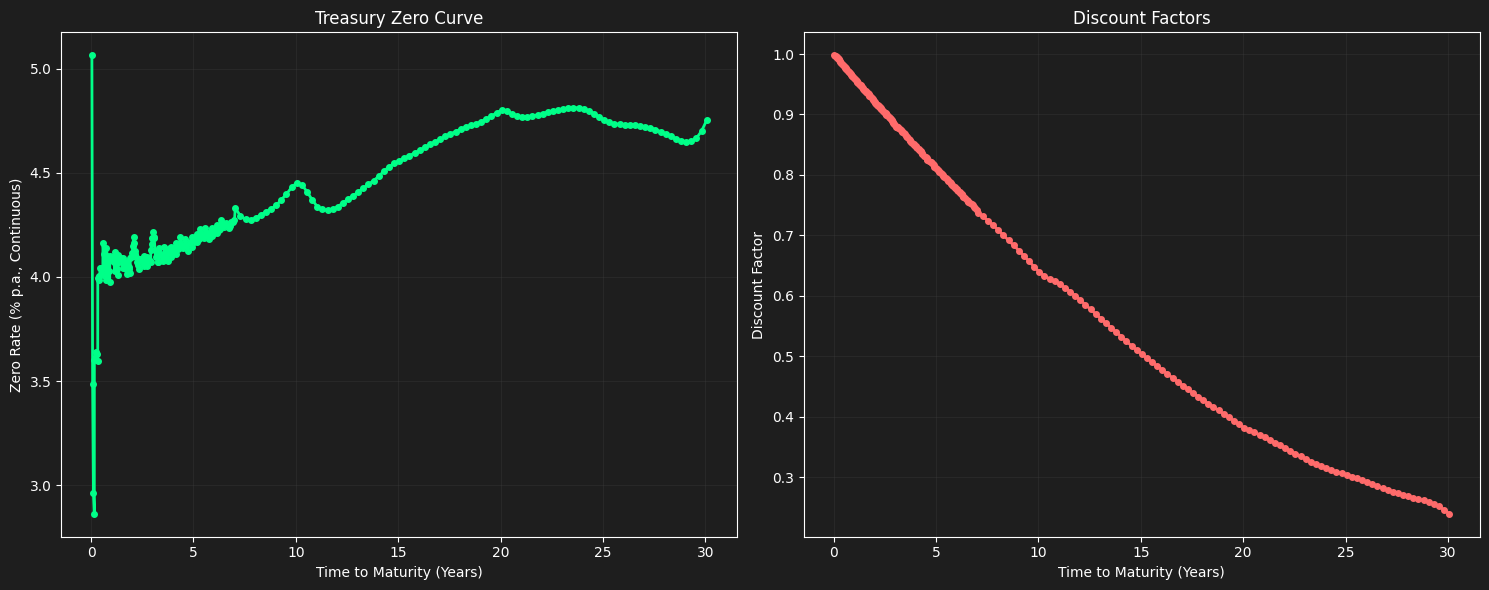

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), facecolor='#1e1e1e')

for ax in [ax1, ax2]:
    ax.set_facecolor('#1e1e1e')
    ax.tick_params(colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    for spine in ax.spines.values():
        spine.set_color('white')

ax1.plot(fitted_curve['time_years'], fitted_curve['zero_rate_continuous'] * 100, '#00ff88', linewidth=2, marker='o', markersize=4)
ax1.set_xlabel('Time to Maturity (Years)')
ax1.set_ylabel('Zero Rate (% p.a., Continuous)')
ax1.set_title('Treasury Zero Curve')
ax1.grid(True, alpha=0.3, color='#404040')

ax2.plot(fitted_curve['time_years'], fitted_curve['discount_factor'], '#ff6b6b', linewidth=2, marker='o', markersize=4)
ax2.set_xlabel('Time to Maturity (Years)')
ax2.set_ylabel('Discount Factor')
ax2.set_title('Discount Factors')
ax2.grid(True, alpha=0.3, color='#404040')

plt.tight_layout()
plt.show()

## Model Validation

Bond pricing validation using the fitted curve:

$$P_{\text{theoretical}} = \sum_{i=1}^{n} C_i \times D(t_i)$$

In [37]:
def validate_pricing_model(bond_portfolio, yield_curve, evaluation_date):
    theoretical_prices = []
    market_prices = compute_dirty_prices(bond_portfolio, evaluation_date)
    
    for _, bond_row in bond_portfolio.iterrows():
        bond_cashflows = construct_bond_cashflows(bond_row, evaluation_date)
        theoretical_price = 0.0
        
        for payment_date, payment_amount in bond_cashflows:
            time_fraction = calculate_time_fraction(evaluation_date, payment_date)
            
            if time_fraction in yield_curve['time_years'].values:
                discount_factor = yield_curve[yield_curve['time_years'] == time_fraction]['discount_factor'].iloc[0]
            else:
                discount_factor = np.interp(time_fraction, yield_curve['time_years'], yield_curve['discount_factor'])
            
            theoretical_price += payment_amount * discount_factor
        
        theoretical_prices.append(theoretical_price)
    
    theoretical_prices = np.array(theoretical_prices)
    pricing_residuals = market_prices - theoretical_prices
    root_mean_square_error = np.sqrt(np.mean(pricing_residuals**2))
    mean_absolute_error = np.mean(np.abs(pricing_residuals))
    
    print(f"Model Validation Results:")
    print(f"RMSE: {root_mean_square_error:.4f}")
    print(f"MAE: {mean_absolute_error:.4f}")
    print(f"Max Absolute Error: {np.max(np.abs(pricing_residuals)):.4f}")
    
    return theoretical_prices, market_prices, pricing_residuals

predicted_prices, observed_prices, residuals = validate_pricing_model(treasury_bonds, fitted_curve, EVALUATION_DATE)

Model Validation Results:
RMSE: 0.2198
MAE: 0.1150
Max Absolute Error: 1.6871


## Pricing Accuracy Analysis

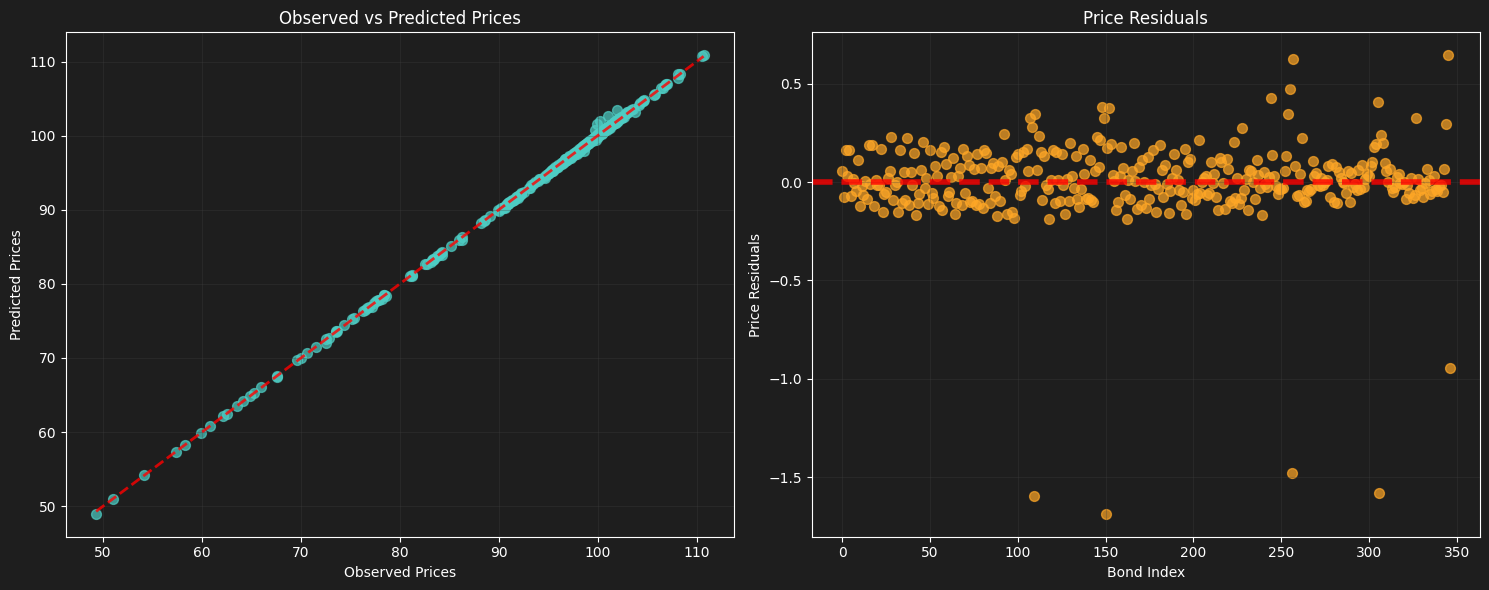

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), facecolor='#1e1e1e')
for ax in [ax1, ax2]:
    ax.set_facecolor('#1e1e1e')
    ax.tick_params(colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    for spine in ax.spines.values():
        spine.set_color('white')

ax1.scatter(observed_prices, predicted_prices, alpha=0.7, color='#4ecdc4', s=50)
ax1.plot([observed_prices.min(), observed_prices.max()], [observed_prices.min(), observed_prices.max()], 'red', linestyle='--', alpha=0.8, linewidth=2)
ax1.set_xlabel('Observed Prices')
ax1.set_ylabel('Predicted Prices')
ax1.set_title('Observed vs Predicted Prices')
ax1.grid(True, alpha=0.3, color='#404040')

ax2.scatter(range(len(residuals)), residuals, alpha=0.7, color='#ffa726', s=50)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=4)
ax2.set_xlabel('Bond Index')
ax2.set_ylabel('Price Residuals')
ax2.set_title('Price Residuals')
ax2.grid(True, alpha=0.3, color='#404040')

plt.tight_layout()
plt.show()

## Results Export

In [39]:
final_results = treasury_bonds.copy()
final_results['Observed_Price'] = observed_prices
final_results['Predicted_Price'] = predicted_prices
final_results['Price_Residual'] = residuals

fitted_curve.to_csv('treasury_zero_curve.csv', index=False)
final_results.to_csv('bond_pricing_results.csv', index=False)

print("Results exported to:")
print("- treasury_zero_curve.csv")
print("- bond_pricing_results.csv")

Results exported to:
- treasury_zero_curve.csv
- bond_pricing_results.csv
